# Parallel CNNS and RNNs

### Loading and Batching the Data

In [ ]:
# Mounting Google Drive in order to access the datasets
from google.colab import drive
drive.mount('/content/drive')

# Defining paths to the training and validation data folders
train_path = '/content/drive/MyDrive/assign2_train'
val_path = '/content/drive/MyDrive/assign2_val'

# Loading pre-saved TensorFlow datasets
import tensorflow as tf
train_dataset = tf.data.Dataset.load(train_path)
val_dataset = tf.data.Dataset.load(val_path)

# Batching the datasets for efficient training
batch_size = 128
train_dataset_batch = train_dataset.batch(batch_size)
val_dataset_batch = val_dataset.batch(batch_size)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Section 1

For this section, I implemented a shallow parallel convolutional neural network. Each image is a 2D image of shape (80, 80, 1), representing time, frequency, and intensity. The model contains two parallel branches. The first branch contains a convolutional layer with 3 filters of size 8, using leaky ReLU activation (slope = 0.3), a max pooling layer with pool size 4, a flattening layer to prepare the output for concatenation. The second contains a convolutional layer with 4 filters of size 4, using leaky ReLU activation (slope = 0.3), a max pooling layer with pool size 2, a flattening layer.

The outputs of both of the branches are concatenated and were passed to a dense softmax layer for classification into 8 genres. The model uses categorical_crossentropy (with one-hot encoded labels), the SGD optimizer, and trains for 50 epochs with a batch size of 128.


### Defining the Parallel CNN Model

In [11]:
from tensorflow.keras import layers, models

# Defining the input shape for 80x80 spectrograms with 1 channel
input_shape = (80, 80, 1)
inputs = tf.keras.Input(shape=input_shape)

# First Branch: Conv2D with 3 filters (8x8), LeakyReLU, and MaxPooling (4x4)
x1 = layers.Conv2D(filters=3, kernel_size=8, padding='same',
                   activation=tf.keras.layers.LeakyReLU(negative_slope=0.3))(inputs)
x1 = layers.MaxPooling2D(pool_size=4)(x1)
x1 = layers.Flatten()(x1)

# Second Branch: Conv2D with 4 filters (4x4), LeakyReLU, and MaxPooling (2x2)
x2 = layers.Conv2D(filters=4, kernel_size=4, padding='same',
                   activation=tf.keras.layers.LeakyReLU(negative_slope=0.3))(inputs)
x2 = layers.MaxPooling2D(pool_size=2)(x2)
x2 = layers.Flatten()(x2)

# Merging the two branches and applying final Dense softmax layer
merged = layers.Concatenate()([x1, x2])
outputs = layers.Dense(8, activation='softmax')(merged)

# The model
model = models.Model(inputs=inputs, outputs=outputs)

### Compiling and Training the Model

In [16]:
# Building and compiling the model using the SGD optimizer
model.compile(
    optimizer=tf.keras.optimizers.SGD(),
    loss='categorical_crossentropy',  # one-hot labels
    metrics=['accuracy']
)


In [17]:
# Trainign the model for 50 epochs
history = model.fit(train_dataset_batch,
                    validation_data=val_dataset_batch,
                    epochs=50)


Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 74s 953ms/step - accuracy: 0.4038 - loss: 1.5966 - val_accuracy: 0.5321 - val_loss: 1.2587
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 65s 864ms/step - accuracy: 0.5763 - loss: 1.1618 - val_accuracy: 0.5658 - val_loss: 1.1472
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 89s 958ms/step - accuracy: 0.6246 - loss: 1.0307 - val_accuracy: 0.5875 - val_loss: 1.0873
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 76s 873ms/step - accuracy: 0.6556 - loss: 0.9485 - val_accuracy: 0.6075 - val_loss: 1.0401
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 84s 910ms/step - accuracy: 0.6803 - loss: 0.8854 - val_accuracy: 0.6250 - val_loss: 0.9986
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 67s 895ms/step - accuracy: 0.6982 - loss: 0.8320 - val_accuracy: 0.6446 - val_loss: 0.9617
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 80s 861ms/step - accuracy: 0.7168 - loss: 0.7853 - val_accuracy: 0.6617 - val_loss: 0.9292
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 85s 906ms/step - accuracy: 0.7355 - loss: 0.7439 - val_accu

### Plotting Results

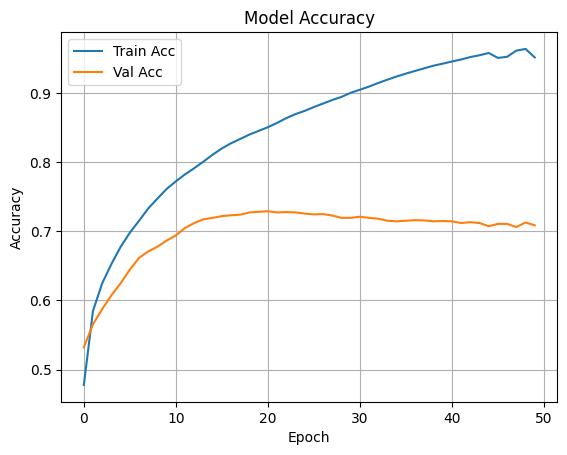

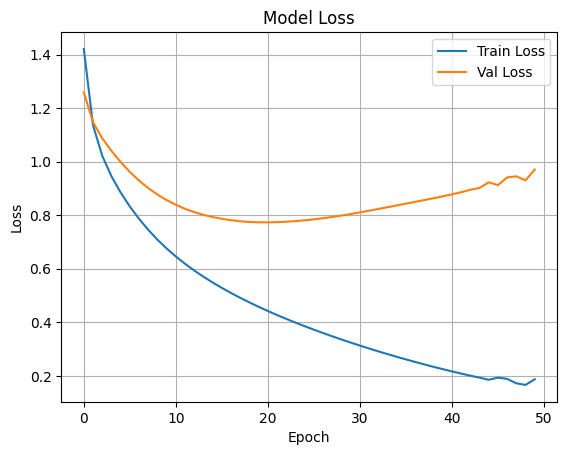

In [18]:
import matplotlib.pyplot as plt

# Plotting training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


The model achieved approximately 72% accuracy on the validation set. Training accuracy continued to improve steadily, while validation accuracy plateaued around epoch 15, with a slight increase in validation loss afterward, indicating mild overfitting.

## Section 2

For Section 2, I implemented a CNN-RNN hybrid model. First, I reduced the input dimensionality by removing the singleton channel dimension using tf.squeeze(). The resulting inputs were of shape (80, 80). The model uses convolutional layers to extract local audio features and LSTMs to capture temporal structure, combining both spatial and sequential information. After two Conv2D and max pooling layers, features are reshaped into a sequence and passed through stacked LSTMs, followed by a dense layer with dropout and a softmax output for genre classification.



### Data Preparation

In [8]:
# Removing singleton channel dimension to reshape input from (80, 80, 1) to (80, 80)
def reduce_dimension(x, y):
    return tf.squeeze(x, axis=-1), y

# Applying reduction to train and validation datasets
train_dataset_squeeze = train_dataset.map(reduce_dimension)
val_dataset_squeeze = val_dataset.map(reduce_dimension)

# Batching and prefetching datasets for training
batch_size = 128
train_dataset_batch = train_dataset_squeeze.batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset_batch = val_dataset_squeeze.batch(batch_size).prefetch(tf.data.AUTOTUNE)



### Model Architecture: Convolutional Frontend and Stacked LSMs

In [9]:
from tensorflow.keras import layers, models

# Inputting layer for squeezed spectograms
input_shape = (80, 80)
inputs = tf.keras.Input(shape=input_shape)

# Expand dims back for Conv2D
x = layers.Lambda(lambda t: tf.expand_dims(t, axis=-1))(inputs)

# First convolutional block
x = layers.Conv2D(filters=8, kernel_size=4, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)

# Second convolutional block
x = layers.Conv2D(filters=6, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)

# Reshaping output to (time_steps, features) for LSTM input
shape = x.shape
x = layers.Reshape((shape[1], shape[2]*shape[3]))(x)

# LSTM layers
x = layers.LSTM(128, return_sequences=True)(x) # returns full sequence
x = layers.LSTM(32)(x) # returns only last hidden state

# Dense layers
x = layers.Dense(200, activation='relu')(x) # with ReLU activation
x = layers.Dropout(0.2)(x) # Dropout to reduce overfitting

# Final Output layer
outputs = layers.Dense(8, activation='softmax')(x)

# Model
model = models.Model(inputs=inputs, outputs=outputs)


### Compiling and Training the Model

In [10]:
# Compiling model using SGD
model.compile(
    optimizer=tf.keras.optimizers.SGD(),
    loss='categorical_crossentropy',  # assuming one-hot labels again
    metrics=['accuracy']
)
# Training the model
history = model.fit(
    train_dataset_batch,
    validation_data=val_dataset_batch,
    epochs=50
)


Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 48s 592ms/step - accuracy: 0.1345 - loss: 2.0784 - val_accuracy: 0.2175 - val_loss: 2.0637
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 551ms/step - accuracy: 0.2115 - loss: 2.0547 - val_accuracy: 0.2425 - val_loss: 2.0254
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 38s 499ms/step - accuracy: 0.2312 - loss: 2.0098 - val_accuracy: 0.2346 - val_loss: 1.9763
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 44s 547ms/step - accuracy: 0.2489 - loss: 1.9583 - val_accuracy: 0.2325 - val_loss: 1.9331
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 543ms/step - accuracy: 0.2557 - loss: 1.9147 - val_accuracy: 0.2454 - val_loss: 1.8999
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 82s 553ms/step - accuracy: 0.2688 - loss: 1.8824 - val_accuracy: 0.2663 - val_loss: 1.8737
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 84s 583ms/step - accuracy: 0.2841 - loss: 1.8567 - val_accuracy: 0.2821 - val_loss: 1.8503
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 39s 526ms/step - accuracy: 0.2892 - loss: 1.8326 - val_accu

### Plotting Results

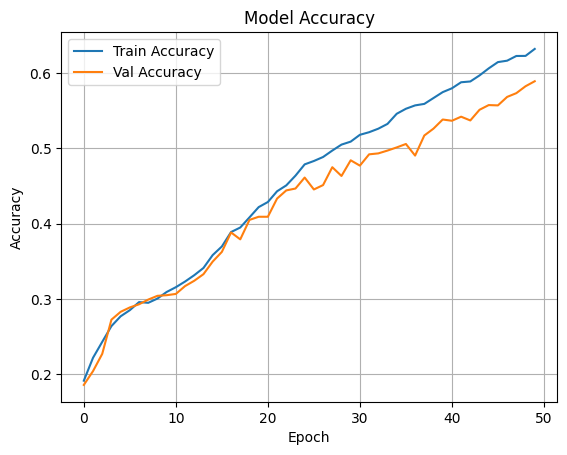

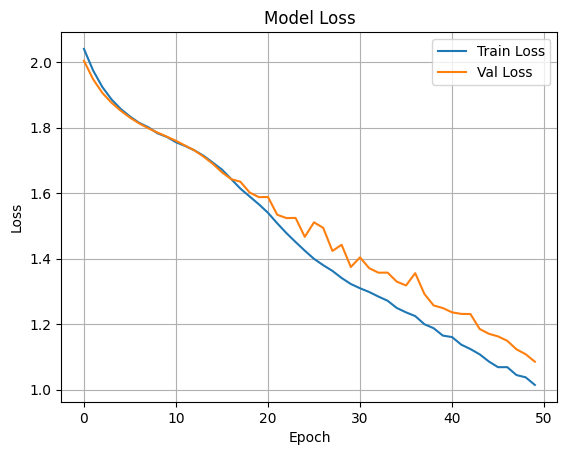

In [23]:
# Plotting the training and validatoin accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


The model achieved around 59% validation accuracy. Training and validation accuracy steadily increased, and loss consistently decreased across epochs with minimal overfitting.This architecture captures both local time-frequency patterns (with CNN) and temporal structure across time (with LSTM), which makes it well-suited to classifying musical sequences.

## Achieving Higher Accuracy

In order to achieve higher accuracy, I implemented a deeper CNN-BiLSTM model with data augmentation in order to improve generalization and achieve higher accuracy. Gaussian noise was added to the input spectrograms to simulate variability and reduce overfitting. The model uses two Conv2D layers with batch normalization and max pooling to extract robust time-frequency features, which are reshaped and fed into two bidirectional LSTM layers to capture temporal patterns in both directions. A dense layer with dropout is used for regularization before the final softmax output layer.

This architecture was chosen to address the limitations of earlier models, which struggled to capture both the local detail and long-range dependencies present in musical structure. The deeper CNN layers enable the model to learn more complex time-frequency patterns, while the use of bidirectional LSTMs ensures that temporal relationships are understood in both past and future contexts. This is essential for genre classification where rhythm and melody evolve over time. Batch normalization and dropout help reduce overfitting, and the addition of noise-based augmentation increases the model's robustness to variation in the data. Together, these choices were made to improve generalization and support more reliable performance on unseen samples, ultimately leading to validation accuracy of around 85%.

### Data Preparation

In [24]:
# Applying Gaussian noise to inputs for data augmentation
def augment(x, y):
    noise = tf.random.normal(shape=tf.shape(x), mean=0.0, stddev=0.05)
    return x + noise, y

# Applying augmentaiton to training data and reduce input dimensions
augmented_train = train_dataset.map(reduce_dimension).map(augment)
val_set = val_dataset.map(reduce_dimension)

# Batching the datasets
batch_size = 128
train_dataset_batch = augmented_train.batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset_batch = val_set.batch(batch_size).prefetch(tf.data.AUTOTUNE)


### Deeper CNN with Bidirectional LSM

In [25]:
from tensorflow.keras import layers, models

# Defining input shape
inputs = tf.keras.Input(shape=(80, 80))

x = layers.Lambda(lambda t: tf.expand_dims(t, axis=-1))(inputs)  # (80, 80, 1)

# First convolutional block with BatchNorm
x = layers.Conv2D(16, kernel_size=3, activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2)(x)

# Second convolutional block with BatchNorm
x = layers.Conv2D(32, kernel_size=3, activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2)(x)

# Reshaping for BiLSTM input
shape = x.shape
x = layers.Reshape((shape[1], shape[2]*shape[3]))(x)

# Bidirectional LSTM layers
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)

# Fully connected dense layer with dropout
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)

# Output layer with softmax for genre classification
outputs = layers.Dense(8, activation='softmax')(x)

# Model
model = models.Model(inputs=inputs, outputs=outputs)


### Compiling and Training Model

In [26]:
# Compiling the model with Adam optimizer
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Training the model for 50 epochs
history = model.fit(
    train_dataset_batch,
    validation_data=val_dataset_batch,
    epochs=50
)


Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - accuracy: 0.4496 - loss: 1.5321 - val_accuracy: 0.2058 - val_loss: 2.0786
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.6974 - loss: 0.8567 - val_accuracy: 0.2604 - val_loss: 2.1233
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.7663 - loss: 0.6522 - val_accuracy: 0.2733 - val_loss: 2.2385
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.8294 - loss: 0.4864 - val_accuracy: 0.3367 - val_loss: 2.1491
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.8723 - loss: 0.3682 - val_accuracy: 0.4517 - val_loss: 1.8013
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.8994 - loss: 0.2951 - val_accuracy: 0.5804 - val_loss: 1.4611
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.9094 - loss: 0.2576 - val_accuracy: 0.6621 - val_loss: 1.1173
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.9328 - loss: 0.1920 - val_accuracy: 0.7133 - v

### Plotting Results

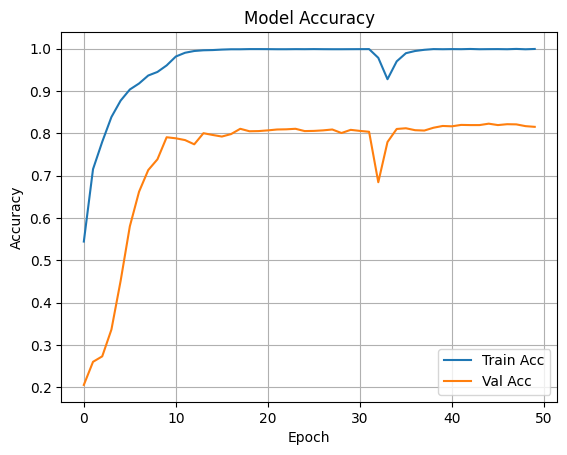

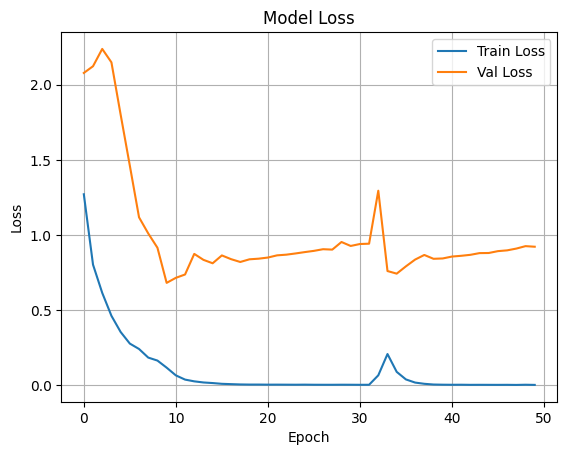

In [27]:
# Plotting the accuracy curves
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the loss curves
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


The model reached ~85% validation accuracy by epoch 10 and maintained it consistently. The validation accuracy was stable, with minor fluctuations, while training accuracy remained near 100%. The validation loss showed a slow upward trend after epoch 15, indicating mild overfitting, which could be addressed with additional regularization or early stopping.